In [14]:
import matplotlib.pyplot as plt
import numpy as np
from pylbm import lbm
from scipy.optimize import curve_fit
import m3_helpers

In [85]:
epochs = 1000
eps = 0.01
omegas = np.arange(0.1, 1.91, 0.2).round(decimals=1)
x_dim, y_dim = 120, 100

### Choose an initial distribution of  $ρ(r,t)$  and  $u(r,t)$  at  $t=0$  such as  $ρ(r,0)=ρ_0+ε \sin(2πx / L_x)$  and  $u(r,0)=0$ . Where  $L_x$  is the length of the domain in the  $x$  direction. Observe what happens with the 2D density distribution in time.

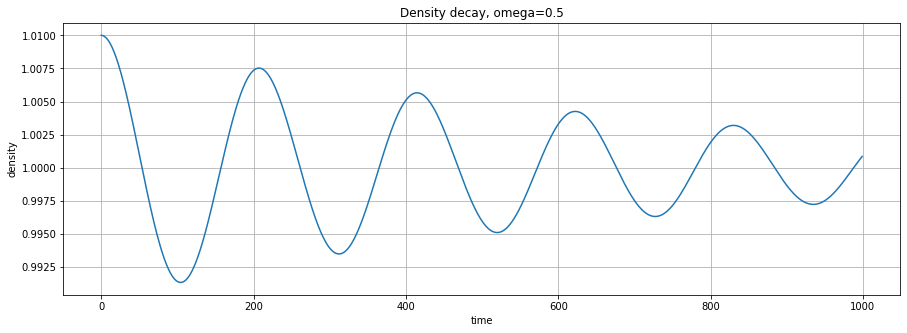

In [92]:
vs_emp, densities = m3_helpers.m3_1(x_dim=x_dim, y_dim=y_dim, eps=eps, epochs=epochs,omega=0.5)
fig, ax = plt.subplots(figsize=(15,5))
plt.axis('off')
ax = fig.subplots(nrows=1, ncols=1)
# ax = axs[0]
densities = np.array(densities)
ax.plot(np.arange(epochs),densities)
ax.set_title("Density decay, omega=0.5")
ax.set_xlabel("time")
ax.set_ylabel("density")
ax.grid(True)
plt.show()
plt.close()

### M3.2 Choose an initial distribution of  $ρ(r,0)=1$  and  $u_x(r,0)=ε\sin(2πy / L_y)$ , i.e. a sinusoidal variation of the velocities  $u_x$  with the position  $y$ . Observe in both cases what happens dynamically as well as in the long time limit  $t→∞$ .

In [93]:
amps_total, velocities_omega_05 = m3_helpers.m3_2(x_dim, y_dim, eps, epochs, omegas)

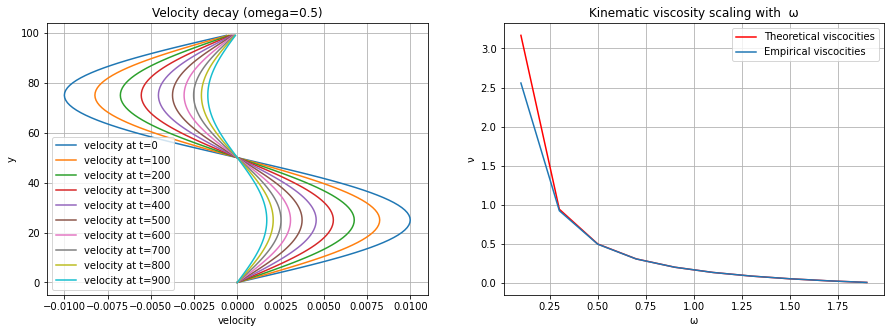

In [94]:
fig, ax = plt.subplots(figsize=(15,5))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=2)

ax = axs[0]
ax.set_title("Velocity decay (omega=0.5)")
ax.set_xlabel("velocity")
ax.set_ylabel("y")
for i in range(0,epochs, int(epochs/10)):
    v = velocities_omega_05[i]
    ax.plot(v[0],np.arange(y_dim), label="velocity at t={}".format(v[1]))
ax.legend()
ax.grid()

ax = axs[1]
nys_emp = []
for amp in amps_total:
    def func(x, a):
        return np.exp(-a*x*((2*np.pi/y_dim)**2))
    popt, pcov = curve_fit(func, np.arange(epochs), amp[1]/amp[1][0])
    nys_emp.append(popt[0])
vs_theo = 1/3*(1/omegas-0.5)
ax.plot(omegas,vs_theo, color='red', label='Theoretical viscocities')
ax.plot(omegas,nys_emp,label='Empirical viscocities')
ax.set_title("Kinematic viscosity scaling with  ω")
ax.set_xlabel('ω')
ax.set_ylabel('ν')
ax.legend()
ax.grid()

plt.show()
plt.close()

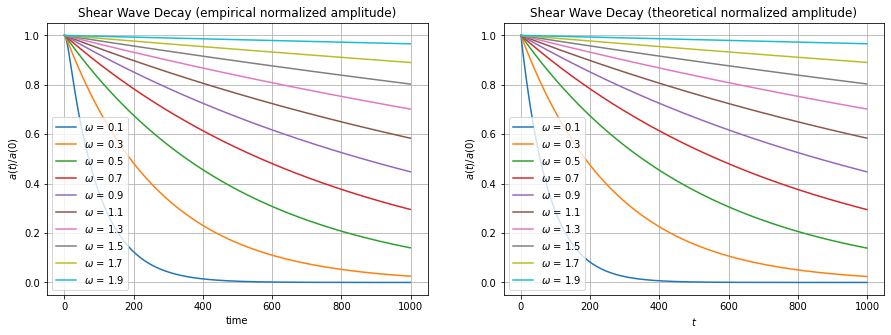

In [95]:
fig, ax = plt.subplots(figsize=(15,5))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=2)

ax = axs[0]
for a in amps_total:
    ax.plot(np.arange(epochs), a[1]/a[1][0], label='$\omega$ = {}'.format(a[0].round(1)))
ax.set_title("Shear Wave Decay (empirical normalized amplitude)")
ax.set_xlabel('time')
ax.set_ylabel('$a(t)/a(0)$')
ax.legend()
ax.grid()

ax = axs[1]
plots = []
for omega in omegas:
    amplitudes = []
    for e in range(epochs):
        nu = 1/3*(1/omega - 1/2)
        amp = np.exp(-nu*(2*np.pi/y_dim)**2*e)
        amplitudes.append(amp)
    plots.append([omega, amplitudes])
for p in plots:
    ax.plot(np.arange(epochs), p[1], label="$\omega$ = {}".format(p[0].round(1)))
ax.set_title("Shear Wave Decay (theoretical normalized amplitude)")
ax.set_xlabel('$t$')
ax.set_ylabel('$a(t)/a(0)$')
ax.legend()
ax.grid()

# fig.savefig("./m3_2")
plt.show()
plt.close()